In [63]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [64]:
input_fname = 'test_toymodel.in'

nTurn = 2048

nCore_y = 1
nCore_z = 1

NL_t = 0.4
NL_c = 0.01
dTune = 0.0

pCrit = 3.258589041249e-3

xSingular = np.array([-1.0,1.0])
ySingular = np.array([0,0])

# 1. Preparation

### 1.1 read InputFile and simplify lattice

In [65]:
beam, lattice = impact.readInputFile(input_fname);
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0
lattice[0].turns = nTurn
betx = beam.distribution.betx
alfx = beam.distribution.alfx

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

pCrit = pCrit/(NL_c*np.sqrt(betx))
xCrit = np.array([pCrit,pCrit])
yCrit = np.linspace(-1.0,1.0,2)

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [66]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [67]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 100
lattice[1].strength_t = NL_t
lattice[2].tune_advance = dTune

### 1.2. generate particles

In [68]:
pTest_tmp=np.load('pOnArc.npy')
npt = len(pTest_tmp)
pTest = np.zeros([npt,9])
q_m = beam.multi_charge.q_m[0]
Diff = np.zeros([npt,3])
for i in range(npt):
    pTest[i,:4]=pTest_tmp[i,:4]
    Diff[i,:]=pTest_tmp[i,4:]
    pTest[i,6]=q_m
    pTest[i,8]=i+1
beam.n_particles = npt
print('initial npt=',npt)

initial npt= 32


In [69]:
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)

# 2. FMA

### 2.1. run

In [70]:
print('===========================')
print('=========== FMA ===========')
print('===========================')

=========== FMA ===========


In [71]:
TBT = impact.getElem('TBT')
TBT.file_id = 1000
lattice.insert(1,TBT)


TBT_Inv = impact.getElem('TBT_integral')
TBT_Inv.file_id = 1000
TBT_Inv.betx = betx
TBT_Inv.alfx = alfx
TBT_Inv.strength_t = NL_t
TBT_Inv.transverse_scale_c = NL_c
lattice.insert(2,TBT_Inv)

impact.writeInputFile(beam,lattice) 
impact.run(beam)

0

In [72]:
indexTBTinv,TBTdataInv = impact.readTBT_integral(1000)
indexTBT,TBTdata = impact.readTBT(1000,ke,mass,freq)
X = (TBTdata[:,0,:] - 1j*(betx*TBTdata[:,1,:]+alfx*TBTdata[:,0,:]))/(NL_c*np.sqrt(betx))
Y = (TBTdata[:,2,:] - 1j*(betx*TBTdata[:,3,:]+alfx*TBTdata[:,2,:]))/(NL_c*np.sqrt(betx))

# Tune Plot

In [73]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode, nSample = arr.shape
    diff = np.abs(ref-arr)
    for i in range(nMode):
        for j in range(nSample):
            if (diff[i,j]>0.5):
                diff[i,j] = 1.0 - diff[i,j]
    return np.min(diff,0)


def resonnace(ix,iy,N):
    if ix==0 and iy==0:
        nux=0
        nuy=0
    else:
        if ix==0:
            nux = np.linspace(-1,1,2)
            nuy = np.linspace(float( N )/iy, float( N )/iy, 2)
        elif iy==0:
            nuy = np.linspace(-1,1,2)
            nux = np.linspace(float( N )/ix, float( N )/ix, 2)
        else:        
            nux = np.linspace(-1,1,2)
            nuy = ix/float(iy)*nux +  N/float(iy)
    return nux,nuy

In [74]:
tuneXbefore= np.zeros([1,npt])
tuneXafter = np.zeros([3,npt])
tuneYbefore= np.zeros([1,npt])
tuneYafter = np.zeros([3,npt])
nturn = int(nTurn/2)
for i in range(npt):
    tuneXbefore[:,i],amp,dummy = impact.util.naff(1,X[:nturn,i],window_id=1)
    tuneXafter [:,i],amp,dummy = impact.util.naff(3,X[nturn:,i],window_id=1)
    tuneYbefore[:,i],amp,dummy = impact.util.naff(1,Y[:nturn,i],window_id=1)
    tuneYafter [:,i],amp,dummy = impact.util.naff(3,Y[nturn:,i],window_id=1)
    
Xdiff = getClosestDiff(tuneXbefore,tuneXafter)
Ydiff = getClosestDiff(tuneYbefore,tuneYafter)
Adiff = np.sqrt(Xdiff**2 +Ydiff**2)

AdiffLog = np.log10(Adiff+1.0e-6)
XdiffLog = np.log10(Xdiff+1.0e-6)
YdiffLog = np.log10(Ydiff+1.0e-6)

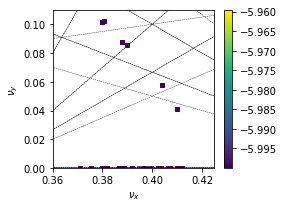

In [81]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.4,ls='--')
f1=plt.scatter(tuneXbefore[0,:],tuneYbefore[0,:],c=AdiffLog,s=16.0,marker='s')
plt.scatter(xSingular,ySingular,c='r',s=77,marker='x')
plt.xlim(np.array([0.36,0.425]))
plt.ylim(np.array([0.0,0.11]))
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.tight_layout()
# plt.close()

# Single Particle Test I

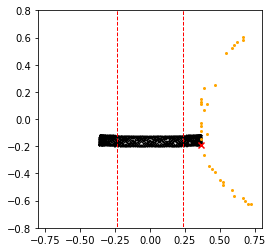

In [82]:
n=0
plt.figure(figsize=(4,4))
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k')
plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),s=4.0,c='orange')
plt.scatter(np.real(X[0,n]),np.real(Y[0,n]),c='r',marker='x')
plt.plot(xCrit,yCrit,c='r',ls='--',lw=1)
plt.plot(-xCrit,yCrit,c='r',ls='--',lw=1)
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);

In [15]:
pTest = np.zeros([1,9])
pTest[0,0]=np.real(X[0,n])
pTest[0,2]=np.real(Y[0,n])
pTest[0,6]=q_m
pTest[0,8]=n
beam.n_particles = 1
print(pTest)
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)
lattice[0].turns = nTurn
impact.writeInputFile(beam,lattice) 
impact.run(beam)

[[3.66E-01 0.00E+00 -1.88E-01 0.00E+00 0.00E+00 0.00E+00 1.07E-09
  0.00E+00 0.00E+00]]


0

In [16]:
x=impact.readRMS('x')
y=impact.readRMS('y')

In [17]:
x = (x.centroid_x - 1j*(betx*x.centroid_px+alfx*x.centroid_x))/(NL_c*np.sqrt(betx))
y = (y.centroid_y - 1j*(betx*y.centroid_py+alfx*y.centroid_y))/(NL_c*np.sqrt(betx))

In [18]:
print(X[0,n],Y[0,n])
print(x[0],y[0])

(0.366262605878255+2.870580382939324e-08j) (-0.1880807976131579-1.474081825227007e-08j)
(0.36626260370232183-5.421496859586844e-11j) (-0.18808079492986807-1.4309694628684315e-09j)


[-1.42E+00 -3.39E+00 -1.42E+00]


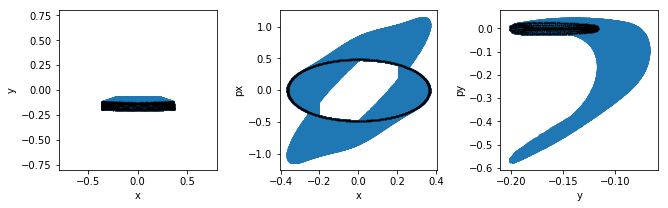

In [19]:
plt.figure(figsize=(9.3,3))
plt.subplot(1,3,1)
plt.scatter(np.real(x),np.real(y),s=0.4)
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);
plt.subplot(1,3,2)
plt.scatter(np.real(x),-np.imag(x),s=0.4)
plt.scatter(np.real(X[:,n]),-np.imag(X[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('px')
plt.subplot(1,3,3)
plt.scatter(np.real(y),-np.imag(y),s=0.4)
plt.scatter(np.real(Y[:,n]),-np.imag(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('y')
plt.ylabel('py')
plt.tight_layout()
print(Diff[n,:])

In [20]:
nStep = len(x)
Sample = []
for i in range(nStep):
    if np.real(x[i]) > xCrit[0] or np.real(x[i]) < -xCrit[0]:
        if np.abs(y[i]) < 0.005:
            Sample.append([x[i],y[i]])
Sample=np.array(Sample)
print(len(Sample))

0


In [21]:
if len(Sample) > 0:
    plt.figure(figsize=(4,4))
    plt.subplot(2,1,1)
    plt.plot(np.real(Sample[:,1]),marker='x',lw=0)
    plt.plot(np.imag(Sample[:,1]),marker='x',lw=0)
    plt.subplot(2,1,2)
    plt.plot(np.real(Sample[:,0]),marker='x',lw=0)
    plt.plot([0,len(Sample)], xCrit,c='r',ls='--')
    plt.plot([0,len(Sample)],-xCrit,c='r',ls='--')

# Single Particle Test I

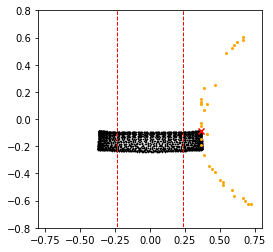

In [22]:
n=2
plt.figure(figsize=(4,4))
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k')
plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),s=4.0,c='orange')
plt.scatter(np.real(X[0,n]),np.real(Y[0,n]),c='r',marker='x')
plt.plot(xCrit,yCrit,c='r',ls='--',lw=1)
plt.plot(-xCrit,yCrit,c='r',ls='--',lw=1)
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);

In [23]:
pTest = np.zeros([1,9])
pTest[0,0]=np.real(X[0,n])
pTest[0,2]=np.real(Y[0,n])
pTest[0,6]=q_m
pTest[0,8]=n
beam.n_particles = 1
print(pTest)
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)
lattice[0].turns = nTurn
impact.writeInputFile(beam,lattice) 
impact.run(beam)

[[3.66E-01 0.00E+00 -8.91E-02 0.00E+00 0.00E+00 0.00E+00 1.07E-09
  0.00E+00 2.00E+00]]


0

In [24]:
x=impact.readRMS('x')
y=impact.readRMS('y')

In [25]:
x = (x.centroid_x - 1j*(betx*x.centroid_px+alfx*x.centroid_x))/(NL_c*np.sqrt(betx))
y = (y.centroid_y - 1j*(betx*y.centroid_py+alfx*y.centroid_y))/(NL_c*np.sqrt(betx))

In [26]:
print(X[0,n],Y[0,n])
print(x[0],y[0])

(0.366262605878255+2.870580382939324e-08j) (-0.08909090413254851-6.982492819970378e-09j)
(0.36626260370232183-5.421496859586844e-11j) (-0.0890909043862269+7.425922314365464e-10j)


[-1.30E+00 -3.20E+00 -1.30E+00]


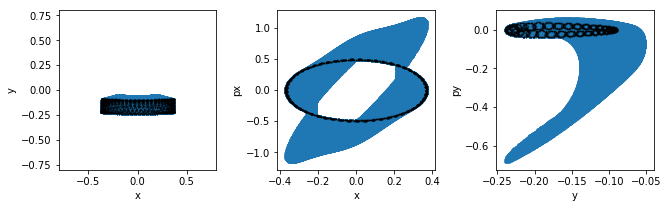

In [27]:
plt.figure(figsize=(9.3,3))
plt.subplot(1,3,1)
plt.scatter(np.real(x),np.real(y),s=0.4)
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);
plt.subplot(1,3,2)
plt.scatter(np.real(x),-np.imag(x),s=0.4)
plt.scatter(np.real(X[:,n]),-np.imag(X[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('px')
plt.subplot(1,3,3)
plt.scatter(np.real(y),-np.imag(y),s=0.4)
plt.scatter(np.real(Y[:,n]),-np.imag(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('y')
plt.ylabel('py')
plt.tight_layout()
print(Diff[n,:])

In [28]:
nStep = len(x)
Sample = []
for i in range(nStep):
    if np.real(x[i]) > xCrit[0] or np.real(x[i]) < -xCrit[0]:
        if np.abs(y[i]) < 0.005:
            Sample.append([x[i],y[i]])
Sample=np.array(Sample)
print(len(Sample))

0


In [29]:
if len(Sample) > 0:
    plt.figure(figsize=(4,4))
    plt.subplot(2,1,1)
    plt.plot(np.real(Sample[:,1]),marker='x',lw=0)
    plt.plot(np.imag(Sample[:,1]),marker='x',lw=0)
    plt.subplot(2,1,2)
    plt.plot(np.real(Sample[:,0]),marker='x',lw=0)
    plt.plot([0,len(Sample)], xCrit,c='r',ls='--')
    plt.plot([0,len(Sample)],-xCrit,c='r',ls='--')

# Single Particle Test I

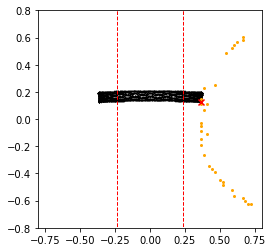

In [30]:
n=6
plt.figure(figsize=(4,4))
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k')
plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),s=4.0,c='orange')
plt.scatter(np.real(X[0,n]),np.real(Y[0,n]),c='r',marker='x')
plt.plot(xCrit,yCrit,c='r',ls='--',lw=1)
plt.plot(-xCrit,yCrit,c='r',ls='--',lw=1)
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);

In [31]:
pTest = np.zeros([1,9])
pTest[0,0]=np.real(X[0,n])
pTest[0,2]=np.real(Y[0,n])
pTest[0,6]=q_m
pTest[0,8]=n
beam.n_particles = 1
print(pTest)
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)
lattice[0].turns = nTurn
impact.writeInputFile(beam,lattice) 
impact.run(beam)

[[3.66E-01 0.00E+00 1.29E-01 0.00E+00 0.00E+00 0.00E+00 1.07E-09 0.00E+00
  6.00E+00]]


0

In [32]:
x=impact.readRMS('x')
y=impact.readRMS('y')

In [33]:
x = (x.centroid_x - 1j*(betx*x.centroid_px+alfx*x.centroid_x))/(NL_c*np.sqrt(betx))
y = (y.centroid_y - 1j*(betx*y.centroid_py+alfx*y.centroid_y))/(NL_c*np.sqrt(betx))

In [34]:
print(X[0,n],Y[0,n])
print(x[0],y[0])

(0.366262605878255+2.870580382939324e-08j) (0.12868686152479233+1.008582292379091e-08j)
(0.36626260370232183-5.421496859586844e-11j) (0.12868686350063316-9.475778389375335e-09j)


[-1.45E+00 -3.59E+00 -1.45E+00]


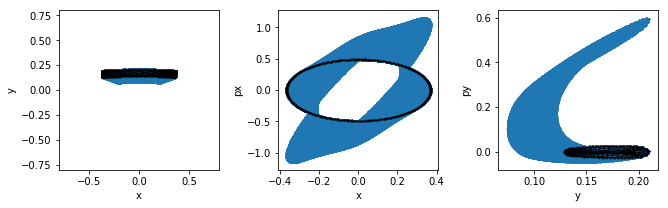

In [35]:
plt.figure(figsize=(9.3,3))
plt.subplot(1,3,1)
plt.scatter(np.real(x),np.real(y),s=0.4)
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);
plt.subplot(1,3,2)
plt.scatter(np.real(x),-np.imag(x),s=0.4)
plt.scatter(np.real(X[:,n]),-np.imag(X[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('px')
plt.subplot(1,3,3)
plt.scatter(np.real(y),-np.imag(y),s=0.4)
plt.scatter(np.real(Y[:,n]),-np.imag(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('y')
plt.ylabel('py')
plt.tight_layout()
print(Diff[n,:])

In [36]:
nStep = len(x)
Sample = []
for i in range(nStep):
    if np.real(x[i]) > xCrit[0] or np.real(x[i]) < -xCrit[0]:
        if np.abs(y[i]) < 0.005:
            Sample.append([x[i],y[i]])
Sample=np.array(Sample)
print(len(Sample))

0


In [37]:
if len(Sample) > 0:
    plt.figure(figsize=(4,4))
    plt.subplot(2,1,1)
    plt.plot(np.real(Sample[:,1]),marker='x',lw=0)
    plt.plot(np.imag(Sample[:,1]),marker='x',lw=0)
    plt.subplot(2,1,2)
    plt.plot(np.real(Sample[:,0]),marker='x',lw=0)
    plt.plot([0,len(Sample)], xCrit,c='r',ls='--')
    plt.plot([0,len(Sample)],-xCrit,c='r',ls='--')

# Single Particle Test I

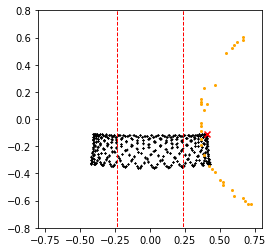

In [38]:
n=11
plt.figure(figsize=(4,4))
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k')
plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),s=4.0,c='orange')
plt.scatter(np.real(X[0,n]),np.real(Y[0,n]),c='r',marker='x')
plt.plot(xCrit,yCrit,c='r',ls='--',lw=1)
plt.plot(-xCrit,yCrit,c='r',ls='--',lw=1)
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);

In [39]:
pTest = np.zeros([1,9])
pTest[0,0]=np.real(X[0,n])
pTest[0,2]=np.real(Y[0,n])
pTest[0,6]=q_m
pTest[0,8]=n
beam.n_particles = 1
print(pTest)
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)
lattice[0].turns = nTurn
impact.writeInputFile(beam,lattice) 
impact.run(beam)

[[4.06E-01 0.00E+00 -1.09E-01 0.00E+00 0.00E+00 0.00E+00 1.07E-09
  0.00E+00 1.10E+01]]


0

In [40]:
x=impact.readRMS('x')
y=impact.readRMS('y')

In [41]:
x = (x.centroid_x - 1j*(betx*x.centroid_px+alfx*x.centroid_x))/(NL_c*np.sqrt(betx))
y = (y.centroid_y - 1j*(betx*y.centroid_py+alfx*y.centroid_y))/(NL_c*np.sqrt(betx))

In [42]:
print(X[0,n],Y[0,n])
print(x[0],y[0])

(0.4058585632704988+3.1809133838987395e-08j) (-0.10888888282867042-8.534157856176249e-09j)
(0.4058585628167281+5.020225032164849e-09j) (-0.10888888394343002+5.109185286849346e-09j)


[-1.65E+00 -2.10E+00 -1.68E+00]


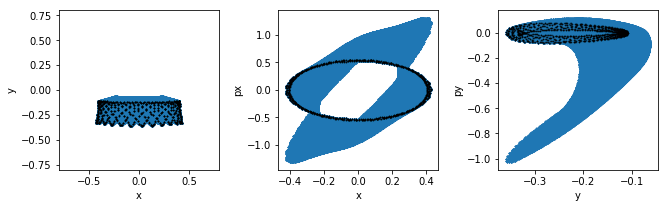

In [43]:
plt.figure(figsize=(9.3,3))
plt.subplot(1,3,1)
plt.scatter(np.real(x),np.real(y),s=0.4)
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);
plt.subplot(1,3,2)
plt.scatter(np.real(x),-np.imag(x),s=0.4)
plt.scatter(np.real(X[:,n]),-np.imag(X[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('px')
plt.subplot(1,3,3)
plt.scatter(np.real(y),-np.imag(y),s=0.4)
plt.scatter(np.real(Y[:,n]),-np.imag(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('y')
plt.ylabel('py')
plt.tight_layout()
print(Diff[n,:])

In [44]:
nStep = len(x)
Sample = []
for i in range(nStep):
    if np.real(x[i]) > xCrit[0] or np.real(x[i]) < -xCrit[0]:
        if np.abs(y[i]) < 0.005:
            Sample.append([x[i],y[i]])
Sample=np.array(Sample)
print(len(Sample))

0


In [45]:
if len(Sample) > 0:
    plt.figure(figsize=(4,4))
    plt.subplot(2,1,1)
    plt.plot(np.real(Sample[:,1]),marker='x',lw=0)
    plt.plot(np.imag(Sample[:,1]),marker='x',lw=0)
    plt.subplot(2,1,2)
    plt.plot(np.real(Sample[:,0]),marker='x',lw=0)
    plt.plot([0,len(Sample)], xCrit,c='r',ls='--')
    plt.plot([0,len(Sample)],-xCrit,c='r',ls='--')

# Single Particle Test I

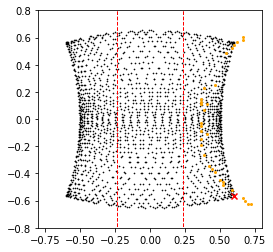

In [46]:
n=22
plt.figure(figsize=(4,4))
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k')
plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),s=4.0,c='orange')
plt.scatter(np.real(X[0,n]),np.real(Y[0,n]),c='r',marker='x')
plt.plot(xCrit,yCrit,c='r',ls='--',lw=1)
plt.plot(-xCrit,yCrit,c='r',ls='--',lw=1)
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);

In [47]:
pTest = np.zeros([1,9])
pTest[0,0]=np.real(X[0,n])
pTest[0,2]=np.real(Y[0,n])
pTest[0,6]=q_m
pTest[0,8]=n
beam.n_particles = 1
print(pTest)
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)
lattice[0].turns = nTurn
impact.writeInputFile(beam,lattice) 
impact.run(beam)

[[6.04E-01 0.00E+00 -5.64E-01 0.00E+00 0.00E+00 0.00E+00 1.07E-09
  0.00E+00 2.20E+01]]


0

In [48]:
x=impact.readRMS('x')
y=impact.readRMS('y')

In [49]:
x = (x.centroid_x - 1j*(betx*x.centroid_px+alfx*x.centroid_x))/(NL_c*np.sqrt(betx))
y = (y.centroid_y - 1j*(betx*y.centroid_py+alfx*y.centroid_y))/(NL_c*np.sqrt(betx))

In [50]:
print(X[0,n],Y[0,n])
print(x[0],y[0])

(0.6038383502317176+4.732578470358678e-08j) (-0.5642423928394737-4.422245463117504e-08j)
(0.6038383511463851-8.315524390078541e-10j) (-0.5642423920319788-7.901633640408952e-09j)


[-1.59E+00 -1.60E+00 -2.49E+00]


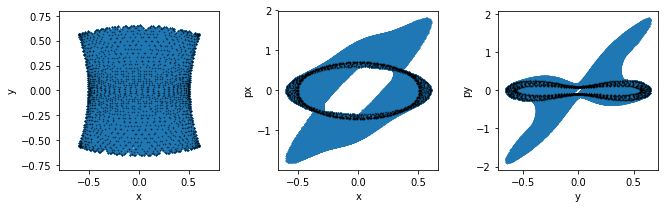

In [51]:
plt.figure(figsize=(9.3,3))
plt.subplot(1,3,1)
plt.scatter(np.real(x),np.real(y),s=0.4)
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);
plt.subplot(1,3,2)
plt.scatter(np.real(x),-np.imag(x),s=0.4)
plt.scatter(np.real(X[:,n]),-np.imag(X[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('px')
plt.subplot(1,3,3)
plt.scatter(np.real(y),-np.imag(y),s=0.4)
plt.scatter(np.real(Y[:,n]),-np.imag(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('y')
plt.ylabel('py')
plt.tight_layout()
print(Diff[n,:])

In [52]:
nStep = len(x)
Sample = []
for i in range(nStep):
    if np.real(x[i]) > xCrit[0] or np.real(x[i]) < -xCrit[0]:
        if np.abs(y[i]) < 0.005:
            Sample.append([x[i],y[i]])
Sample=np.array(Sample)
print(len(Sample))

0


In [53]:
if len(Sample) > 0:
    plt.figure(figsize=(4,4))
    plt.subplot(2,1,1)
    plt.plot(np.real(Sample[:,1]),marker='x',lw=0)
    plt.plot(np.imag(Sample[:,1]),marker='x',lw=0)
    plt.subplot(2,1,2)
    plt.plot(np.real(Sample[:,0]),marker='x',lw=0)
    plt.plot([0,len(Sample)], xCrit,c='r',ls='--')
    plt.plot([0,len(Sample)],-xCrit,c='r',ls='--')

# Single Particle Test I

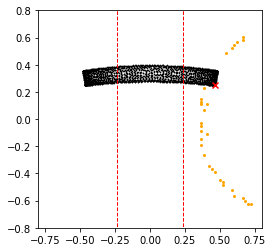

In [54]:
n=31
plt.figure(figsize=(4,4))
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k')
plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),s=4.0,c='orange')
plt.scatter(np.real(X[0,n]),np.real(Y[0,n]),c='r',marker='x')
plt.plot(xCrit,yCrit,c='r',ls='--',lw=1)
plt.plot(-xCrit,yCrit,c='r',ls='--',lw=1)
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);

In [55]:
pTest = np.zeros([1,9])
pTest[0,0]=np.real(X[0,n])
pTest[0,2]=np.real(Y[0,n])
pTest[0,6]=q_m
pTest[0,8]=n
beam.n_particles = 1
print(pTest)
unnormalize(pTest)
impact.writeParticleData(pTest, ke, mass, freq)
lattice[0].turns = nTurn
impact.writeInputFile(beam,lattice) 
impact.run(beam)

[[4.65E-01 0.00E+00 2.47E-01 0.00E+00 0.00E+00 0.00E+00 1.07E-09 0.00E+00
  3.10E+01]]


0

In [56]:
x=impact.readRMS('x')
y=impact.readRMS('y')

In [57]:
x = (x.centroid_x - 1j*(betx*x.centroid_px+alfx*x.centroid_x))/(NL_c*np.sqrt(betx))
y = (y.centroid_y - 1j*(betx*y.centroid_py+alfx*y.centroid_y))/(NL_c*np.sqrt(betx))

In [58]:
print(X[0,n],Y[0,n])
print(x[0],y[0])

(0.4652524993588642+3.646412951296327e-08j) (0.24747473370152356+1.9395813423705266e-08j)
(0.4652525014883376-8.079554149777946e-09j) (0.2474747336014775+2.138816423920746e-09j)


[-6.00E+00 -6.00E+00 -6.00E+00]


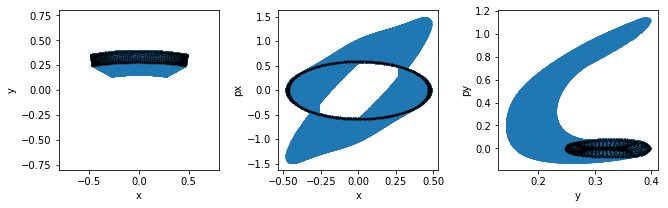

In [59]:
plt.figure(figsize=(9.3,3))
plt.subplot(1,3,1)
plt.scatter(np.real(x),np.real(y),s=0.4)
plt.scatter(np.real(X[:,n]),np.real(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.8,0.8);
plt.ylim(-0.8,0.8);
plt.subplot(1,3,2)
plt.scatter(np.real(x),-np.imag(x),s=0.4)
plt.scatter(np.real(X[:,n]),-np.imag(X[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('x')
plt.ylabel('px')
plt.subplot(1,3,3)
plt.scatter(np.real(y),-np.imag(y),s=0.4)
plt.scatter(np.real(Y[:,n]),-np.imag(Y[:,n]),s=0.4,c='k',alpha=0.5)
plt.xlabel('y')
plt.ylabel('py')
plt.tight_layout()
print(Diff[n,:])

In [60]:
nStep = len(x)
Sample = []
for i in range(nStep):
    if np.real(x[i]) > xCrit[0] or np.real(x[i]) < -xCrit[0]:
        if np.abs(y[i]) < 0.005:
            Sample.append([x[i],y[i]])
Sample=np.array(Sample)
print(len(Sample))

0


In [61]:
if len(Sample) > 0:
    plt.figure(figsize=(4,4))
    plt.subplot(2,1,1)
    plt.plot(np.real(Sample[:,1]),marker='x',lw=0)
    plt.plot(np.imag(Sample[:,1]),marker='x',lw=0)
    plt.subplot(2,1,2)
    plt.plot(np.real(Sample[:,0]),marker='x',lw=0)
    plt.plot([0,len(Sample)], xCrit,c='r',ls='--')
    plt.plot([0,len(Sample)],-xCrit,c='r',ls='--')